In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# Reflect Database into ORM class
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date

In [11]:
#columns in measurements
#can also just go look at the excel file
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_datetime=dt.datetime.strptime(last_date[0],'%Y-%m-%d')
year_ago = (last_datetime - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f'The date 1 year ago from the last data point is {year_ago}.')

The date 1 year ago from the last data point is 2016-08-23.


In [13]:
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
precip_data = session.query(*sel).filter(Measurement.date >= year_ago).all()
#precip_data

In [14]:
# Save the query results as a Pandas DataFrame
precip_df = pd.DataFrame(precip_data, columns=['date', 'precipitation (inches)'])
precip_df['date']=pd.to_datetime(precip_df['date'])
#drop nan rows
precip_df = precip_df.dropna(how='any') 
precip_df.head(10)

,date,precipitation (inches)
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00
5,2016-08-28,0.01
6,2016-08-29,0.00
7,2016-08-30,0.00
8,2016-08-31,0.13
9,2016-09-01,0.00


In [15]:
#set the index to the date column
#sort the dataframe by date
precip_df = precip_df.sort_values(by="date", ascending=True)
precip_df.set_index('date', inplace=True)
precip_df.head(10)

,precipitation (inches)
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
2016-08-23,1.79
2016-08-24,1.22
2016-08-24,0.08
2016-08-24,2.15


In [16]:
#creating a copy of the df with the index reset
#so I can use the column when plotting
df=precip_df.reset_index(drop=False)
#convert the date column to datetime, so we can set the axis
#maybe not necessary?
df['date']=pd.to_datetime(df['date'])


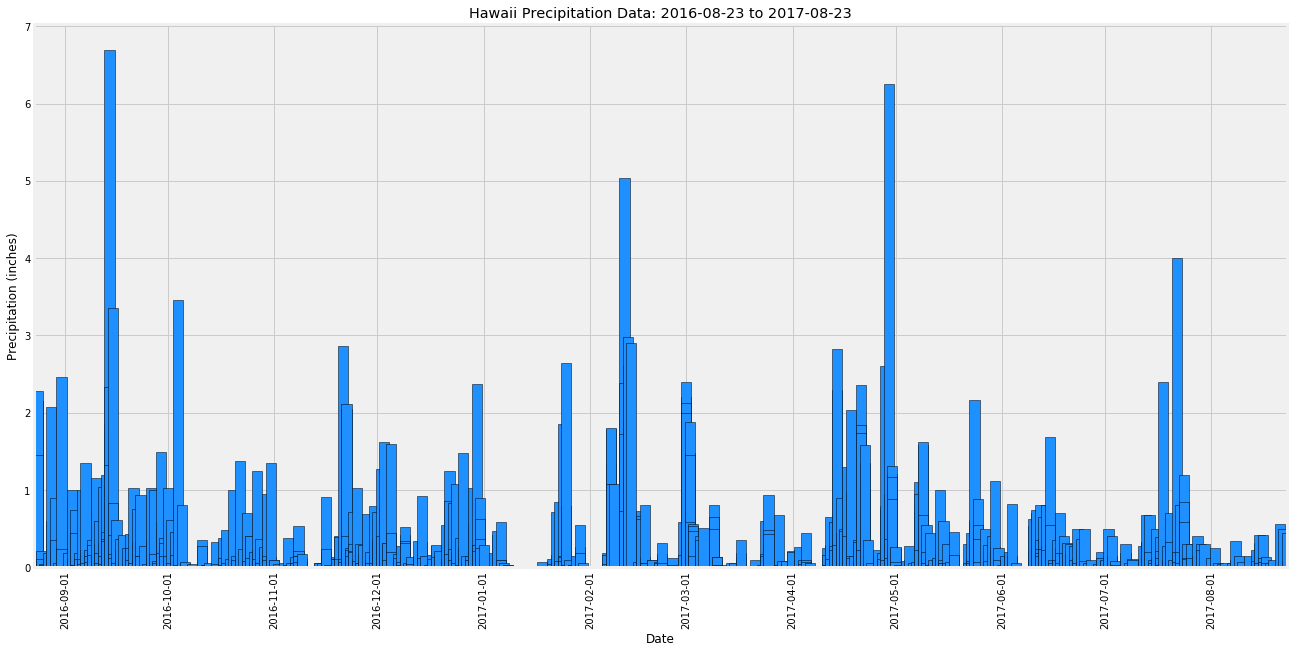

In [58]:
# Use Pandas Plotting with Matplotlib to plot the data

#import, something about converting datetimes in matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#create plot
xax=df.date
yax=df['precipitation (inches)']
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title(f'Hawaii Precipitation Data: {year_ago} to {last_date[0]}')


plt.bar(xax,yax,color='dodgerblue',edgecolor='black',width=3)
plt.xticks(rotation=90)

#Formatting the x axis with date intervals: this took a while to figure out
#import to format date x axis, need the date column to be in datetime format, done previously
from matplotlib.dates import MonthLocator, DateFormatter


ax = plt.gca()
#set the limits to the last and most recent dates
ax.set_xlim(year_ago,last_datetime)

#monthlocator creates month intervals, can also use hourlocator, daylocator, etc.
#https://matplotlib.org/3.1.0/api/dates_api.html#matplotlib.dates.MonthLocator
ax.xaxis.set_major_locator(MonthLocator(bymonthday=1))
#format the date to show year-month-day
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

plt.savefig("Images/precip_data.png")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
#look at columns in stations table
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Design a query to show how many stations are available in this dataset?
print(f'There are {session.query(Station.id).count()} stations.')

There are 9 stations.


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
active_stations= session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
# put into df
active_stations_df=pd.DataFrame(active_stations,columns=['Station','Data Point Count'])
active_stations_df.set_index('Station', inplace=True)
active_stations_df

,Data Point Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel=[Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
top_station= session.query(*sel).filter(Measurement.station==active_stations[0][0]).all()
#not necessary but we will put into table
top_station_df=pd.DataFrame(top_station,columns=['Station','Lowest Temp','Highest Temp','Average Temp'])
top_station_df.set_index('Station', inplace=True)
top_station_df

,Lowest Temp,Highest Temp,Average Temp
Station,,,
USC00519281,54.0,85.0,71.663781


In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#find the lastest date for this station
latest_date=session.query(Measurement.date).filter(Measurement.station==active_stations[0][0]).\
    order_by(Measurement.date.desc()).first()
latest_datetime=dt.datetime.strptime(latest_date[0],'%Y-%m-%d')
latest_datetime
year_ago_date = (latest_datetime - dt.timedelta(days=365)).strftime('%Y-%m-%d')
year_ago_date
print(f'Last 12 months data for {active_stations[0][0]}: {year_ago_date} to {latest_date[0]} ')

Last 12 months data for USC00519281: 2016-08-18 to 2017-08-18 


In [24]:
#Query and put into dataframe
sel = [Measurement.date, Measurement.tobs]
temp_data = session.query(*sel).filter(Measurement.station==active_stations[0][0]).\
    filter(Measurement.date >= year_ago_date).all()
temp_data_df=pd.DataFrame(temp_data,columns=['date','temperature'])
temp_data_df.head()

,date,temperature
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


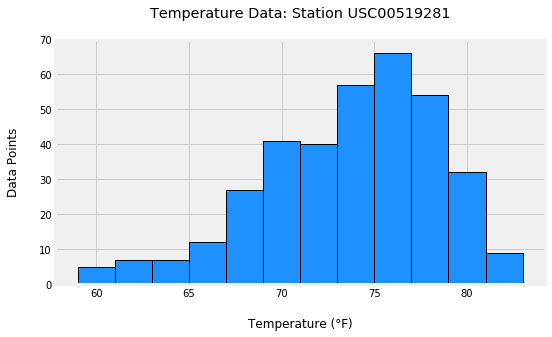

In [56]:
#histogram
temps= temp_data_df.temperature

plt.figure(figsize=(8,5))
plt.title(f'Temperature Data: Station {active_stations[0][0]}\n')
plt.xlabel('\nTemperature (°F)')
plt.ylabel('Data Points\n')
plt.ylim(0,70)

plt.hist(temps,bins=12,color='dodgerblue',edgecolor='black', linewidth=1)
#adjust plot so when you save the image it isn't cut off
plt.gcf().subplots_adjust(left=0.10,bottom=0.2)
plt.savefig("Images/active_station_hist.png")
plt.show()

# Bonus Challenge Assignment

# Temperature Analysis I

In [26]:
#Identify the average temperature in June at all stations across all available years in the dataset. 
#use this extract to get only june and december months
from sqlalchemy import extract 
sel=[Measurement.station, func.avg(Measurement.tobs)]
june_data=session.query(Measurement.station,func.avg(Measurement.tobs)).filter(extract('month', Measurement.date) == 6).\
                    group_by(Measurement.station).all()

#putting the averages into list
june_data_list=[avg for station,avg in june_data]
june_data

[('USC00511918', 74.13939393939394),
 ('USC00513117', 74.05084745762711),
 ('USC00514830', 76.00537634408602),
 ('USC00516128', 71.9372197309417),
 ('USC00517948', 76.6554054054054),
 ('USC00518838', 73.39473684210526),
 ('USC00519281', 73.27118644067797),
 ('USC00519397', 77.55932203389831),
 ('USC00519523', 76.66810344827586)]

In [27]:
#Do the same for December temperature.
dec_data=session.query(Measurement.station,func.avg(Measurement.tobs)).filter(extract('month', Measurement.date) == 12).\
                    group_by(Measurement.station).all()

dec_data_list=[avg for station,avg in dec_data]
#dec_data_list
dec_data

[('USC00511918', 69.6842105263158),
 ('USC00513117', 71.06944444444444),
 ('USC00514830', 73.2247191011236),
 ('USC00516128', 69.29126213592232),
 ('USC00517948', 71.8348623853211),
 ('USC00518838', 72.42105263157895),
 ('USC00519281', 69.90322580645162),
 ('USC00519397', 71.10952380952381),
 ('USC00519523', 72.43333333333334)]

In [28]:
#look at the averages
print(f'Average June Temps: {sum(june_data_list)/len(june_data_list)}')
print(f'Average December Temps: {sum(dec_data_list)/len(dec_data_list)}')

Average June Temps: 74.85351018249017
Average December Temps: 71.21907046377945


In [29]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why?
stats.ttest_ind(june_data_list, dec_data_list, equal_var=False)

Ttest_indResult(statistic=4.615865424404701, pvalue=0.0003657335214469917)

Here we used an unpaired t-test. The date for June and December are independent of each other.

The null hypothesis assumes that the difference between the means is equal to zero (means are equal).
The alternative hypothesis assumes that the difference between the means is not equal to zero (means are different).

The p value from the unpaired t-test, 0.000365 is statistically significant (<05). 
Therefore, we reject the null hypothesis, and accept the alternative hypothesis.

# Temperature Analysis II

In [30]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
vacation_start='2012-07-01'
vacation_end='2012-07-10'
my_vacation=calc_temps(vacation_start, vacation_end )
print(my_vacation)

[(68.0, 74.52777777777777, 81.0)]


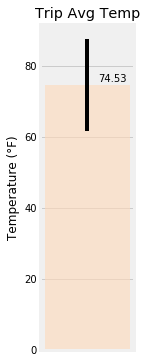

In [81]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


yerror=my_vacation[0][2]-my_vacation[0][0]

fig,ax = plt.subplots(figsize=(2,6))
ax.bar(1,my_vacation[0][1],color='peachpuff',alpha=.6)
ax.set_xticklabels([])
ax.grid(axis='x')
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (°F)')
plt.errorbar(1,my_vacation[0][1],yerr=yerror,color='black')
plt.text(1.1, my_vacation[0][1]+1, f'{round(my_vacation[0][1],2)}',ha='left')

#plt.tight_layout()
plt.gcf().subplots_adjust(left=0.30)
plt.savefig("Images/trip_temp_analysis.png")
plt.show()


# Daily Rainfall Average

In [33]:
#previous year vacation dates
previous_year_start = (dt.datetime.strptime(vacation_start,'%Y-%m-%d') - dt.timedelta(days=366)).strftime('%Y-%m-%d')
previous_year_end = (dt.datetime.strptime(vacation_end,'%Y-%m-%d') - dt.timedelta(days=366)).strftime('%Y-%m-%d')
print(previous_year_start)
print(previous_year_end)

2011-07-01
2011-07-10


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel=[Station.station,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation]
vacation_precip = session.query(*sel).join(Station, Station.station == Measurement.station).\
                    filter(Measurement.date >= previous_year_start).\
                    filter(Measurement.date <= previous_year_end).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()
vacation_precip_df=pd.DataFrame(vacation_precip,columns=\
                                ['station','total precipitation (inches)','station name','latitude','longitude','elevation'])
vacation_precip_df.set_index('station', inplace=True)
vacation_precip_df

,total precipitation (inches),station name,latitude,longitude,elevation
station,,,,,
USC00516128,1.12,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00518838,0.79,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
USC00519281,0.48,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00514830,0.47,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00519523,0.44,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00513117,0.42,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519397,0.15,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00511918,0.07,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
USC00517948,0.00,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

#base = datetime.datetime.today()
vac_start='{:%m-%d}'.format(dt.datetime.strptime(vacation_start,'%Y-%m-%d'))
vac_end='{:%m-%d}'.format(dt.datetime.strptime(vacation_end,'%Y-%m-%d'))
#date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]


In [37]:
#need add a day to our original end date, np array doesnt include the last value
vacation_end_new=(dt.datetime.strptime(vacation_end,'%Y-%m-%d')+dt.timedelta(days=1)).strftime('%Y-%m-%d')

#create a numpy array of dates for our vacation days
vacation_dates=np.arange(vacation_start, vacation_end_new, dtype='datetime64[D]')
#array is in numpy.datetime, conver to string first (str()), then format with month-day only
vac_dates=['{:%m-%d}'.format(dt.datetime.strptime(str(date),'%Y-%m-%d')) for date in vacation_dates]
#vac_dates

In [38]:
normals_data=[]
for d in vac_dates:
    normals_data.append(daily_normals(d)[0])
#normals_data

In [39]:
#ignore this cell

# for d in vac_dates:
#     normals_data={}
#     for min, avg, max in daily_normals(d):
#         normals_data['tmin']=min
#         normals_data['tavg']=avg
#         normals_data['tmax']=max
# normals_data

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df=pd.DataFrame(normals_data,columns=['tmin','tavg','tmax'])
normal_df['date']=vacation_dates
normal_df.set_index('date',inplace=True)
normal_df

,tmin,tavg,tmax
date,,,
2012-07-01,67.0,74.777778,81.0
2012-07-02,68.0,75.403846,82.0
2012-07-03,68.0,75.320755,87.0
2012-07-04,70.0,76.571429,81.0
2012-07-05,66.0,75.000000,81.0
2012-07-06,69.0,75.000000,81.0
2012-07-07,69.0,74.910714,82.0
2012-07-08,69.0,76.083333,83.0
2012-07-09,68.0,76.192982,83.0


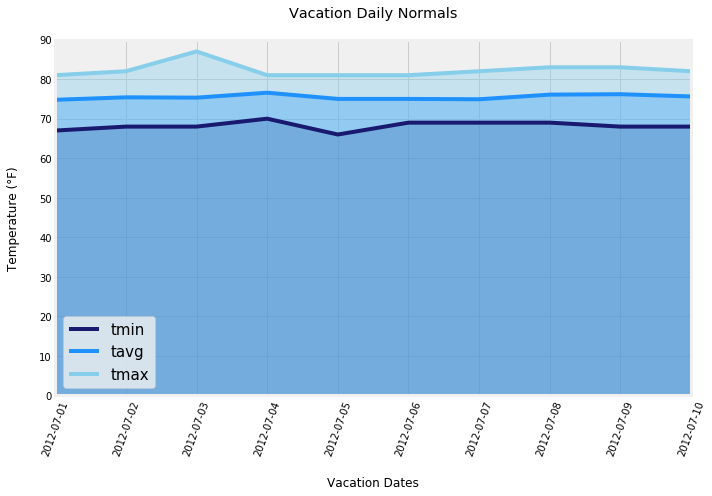

In [48]:
#I ended up plotting this twice, with matplotlib and dataframe.plot.area
# I used matplotlib because I couldn't figure out how to format the dates on the x_axis using dataframe.plot

#Here is the matplotlib
#matplotlib doesn't have an area plot built in so you have to do it manually
#took more effort but I think it looks better

#plot formatting
plt.figure(figsize=(10,7))
plt.xticks(rotation=70)
plt.ylim(0,90)

#removes the margins to the left and right of the outer edges
plt.margins(x=0)

#plot the lines
plt.plot(normal_df.index,normal_df.tmin,color='midnightblue',label='tmin')
plt.plot(normal_df.index,normal_df.tavg,color='dodgerblue',label='tavg')
plt.plot(normal_df.index,normal_df.tmax,color='skyblue',label='tmax')
#imitates the area plot, filling color to the line
plt.fill_between(normal_df.index,normal_df.tmin,color='midnightblue', alpha=0.4)
plt.fill_between( normal_df.index,normal_df.tavg,color='dodgerblue', alpha=0.4)
plt.fill_between(normal_df.index,normal_df.tmax,color='skyblue', alpha=0.4)
#labels
plt.title('Vacation Daily Normals\n')
plt.ylabel('Temperature (°F)\n')
plt.xlabel('\nVacation Dates')

ax=plt.gca()
plt.tight_layout()
#set location and the size of the legend
plt.legend(loc='lower left',prop={'size': 15})

plt.savefig("Images/vacation_daily_norms.png")

plt.show()

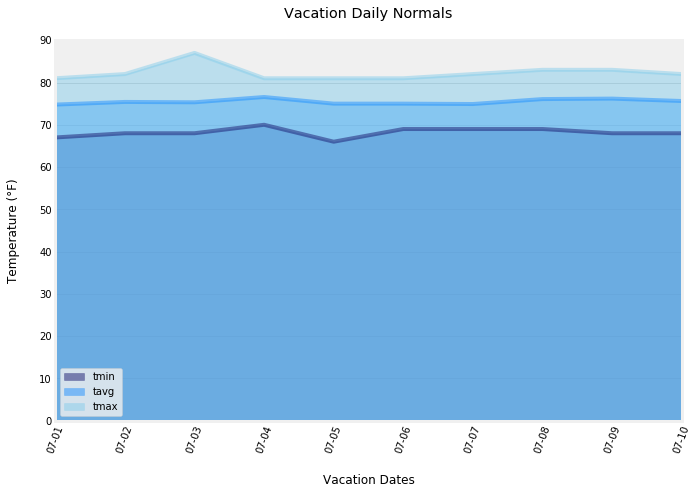

In [42]:
# Plot the daily normals as an area plot with `stacked=False`
ax=normal_df.plot.area(stacked=False,color=['midnightblue','dodgerblue','skyblue'],figsize=(10,7),ylim=(0,95),rot=70)
#normal_df.index=pd.to_datetime(normal_df.index)

ax.set_ylim(0,90)
#pandas.plot really didn't like the date format, using the DateFormatter with %Y-%m-%d kept spitting out the wrong year
#it worked fine with just "%m-%d"

# ax.xaxis.set_minor_formatter(DateFormatter("%Y-%m-%d"))
# ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
ax.xaxis.set_minor_formatter(DateFormatter("%m-%d"))
ax.xaxis.set_major_formatter(DateFormatter("%m-%d"))

plt.title('Vacation Daily Normals\n')
plt.ylabel('Temperature (°F)\n')
plt.xlabel('\nVacation Dates')

plt.show()